In [1]:
import IPython

# Domestic Robotics Architecture

This tutorial aims to describe the main principles behind the design of our domestic robotics architecture as well as its intended use.

## List of contents

1. [Domestic Software 101](#Domestic-Software-101)
2. [Robot-Indepenent and Robot-Dependent Functionalities](#Robot-Independent-and-Robot-Dependent-Functionalities)
    1. [Skill-Based Architecture](#Skill-Based-Architecture)
    2. [ROS-Based and ROS-Independent Components](#ROS-Based-and-ROS-Independent-Components)
    3. [Multi-Repository Setup](#Multi-Repository-Setup)
3. [Major Robot-Independent Components](#Major-Robot-Independent-Components)
4. [Planning and Knowledge-Oriented Development](#Planning--and-Knowledge-Oriented-Development)
5. [Common Interfaces in mas_domestic_robotics](#Common-Interfaces-in-mas_domestic_robotics)
6. [Fault-Tolerant Actions](#Fault-Tolerant-Actions)
7. [Skill Implementation Use Case: Move Base](#Skill-Implementation-Use-Case:-Move-Base)
    1. [Action Server](#Action-Server)
    2. [Action Execution Implementation](#Action-Execution-Implementation)
    3. [Action Client](#Action-Client)
8. [Scenario Use Case: Simple Pick and Place](#Scenario-Use-Case:-Simple-Pick-and-Place)
    1. [Scenario Description](#Scenario-Description)
    2. [Scenario State Machine Definition](#Scenario-State-Machine-Definition)
    3. [Example Behaviour Implementation: Move Base](#Example-Behaviour-Implementation:-Move-Base)
9. [About This Tutorial](#About-This-Tutorial)

## Domestic Software 101

### Skill-Based Architecture

Our domestic architecture is based on the concepts of skills and behaviours that, when combined together, allow a robot to perform complex tasks.

We distinguish between skills and behaviours as follows:
* **skills** are "primitive" functionalities that a robot can perform (and are thus equivalent to actions in the classical planning sense)
* **behaviours** change the context in which actions are performed and thus usually reparameterise skills in some manner

It is clearly difficult - if not impossible - to come up with a generic level of granularity of skills and behaviours. We have attempted to make use of what is generally done in the robotics literature, such that we have implementations of skills such as `move base`, `turn base`, `pickup`, `place`, `perceive plane`; on the other hand, we have behaviours such as `pick_closest_from_surface`, `place_based_on_category`, although we also have generic behaviours that exactly match the skill names (e.g. `move_base` or `place`), which have a default set of assumptions about the actions and their context.

### ROS-Based and ROS-Independent Components

For historical purposes, **our domestic architecture is ROS-based at its core**. Since both robots that we are currently working with - the Care-O-bot 3 and the Toyota HSR - heavily rely on ROS, having a ROS-based architecture simplifies the integration of our functionalities with the already existing robot components (for instance sensor drivers and navigation components); in addition, ROS makes it possible to develop different components in different programming languages, which is nice since it allows our developers to use the language they feel most comfortable with for achieving a certain purpose.

While ROS-based architectures have various advantages, **completely relying on ROS makes it a bit difficult to use certain best practices in software engineering and often introduces an unnecessary overhead in how components are used**. This has sometimes lead to difficult-to-maintain components in our code base.

So, while we do rely on ROS as a backbone, our architecture also makes use of various home-made ROS-indepenent components that are meant to eliminate some of the disadvantages mentioned above. One caveat of this is that most of our domestic software is now written in Python (since we currently only support ROS kinetic, we still live in the past and use Python 2).

### Multi-Repository Setup

Given all different aspects that need to be taken into account to make robots useful (perception, navigation, manipulation, reasoning), robot software tends to get quite complex in practice and managing all different components can be fairly complicated. In order to simplify this management process, **our architecture makes use of a multi-repository setup with various major components being hosted in separate repositories rather than in a monolithic repository**.

A multi-repository setup eases the treatment of different functionalities and allows developers to focus on different aspects without interfering with each other (too much). The downside of this is that it becomes difficult to get a development setup up and running since the repository dependencies need to be clearly specified. To alleviate this problem, we make extensive use of advanced tooling; in particular, we:

* specify dependencies of a repository in rosinstall files and use `wstool` for acquiring them automatically
* make use of continuous integration (in particular `Travis`)

## Robot-Independent and Robot-Dependent Functionalities

Unfortunately, robots often get outdated and it sometimes becomes necessary to replace a platform with a newer one. To make the accommodation of new platforms as painless as possible, our architecture distinguishes between *robot-independent* and *robot-dependent* components:

* **Robot-independent components occupy the core of our architecture** and are implemented in a way that - hopefully - makes as few robot-dependent assumptions as possible, which should simplify the process of interfacing with new robots when the need for that arises
* **Robot-dependent components** either **inherit from the robot-independent components** or simply make use of the robot-independent components by **reparameterising them for a specific robot platform**.

To give an example, our robot-independent code base includes implementations of various robot actions, such as `pick`, `place`, `move base`, and so forth; these are parameterised as much as possible (for example, ROS topic names that are likely to have different names for different robots are made parameters) so that using them on a different robot is mostly a matter of setting the correct values for those parameters (although this is how everything should work in theory, in practice we often find that implementations do indeed have various robot-dependent assumptions, which requires rethinking of components).

## Major Robot-Independent Components

Our primary repository that contains the core functionalities is [mas_domestic_robotics](https://github.com/b-it-bots/mas_domestic_robotics); that is where we have all our skills and behaviours and all the "glue" code that combines everything together. This repository is however in the center of a multitude of repositories that we use. A diagram illustrating the interaction between various repositories of ours is shown below.

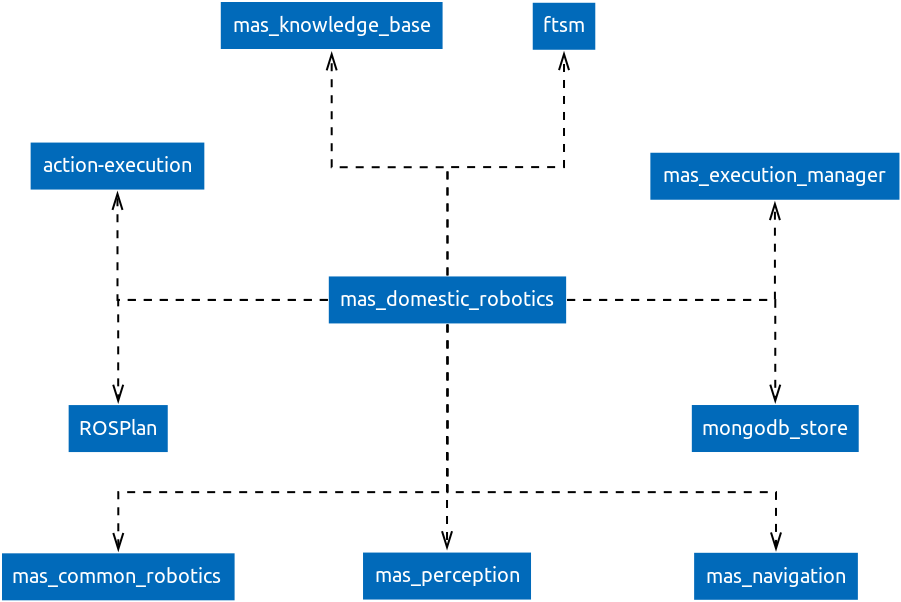

In [2]:
IPython.core.display.Image('https://raw.githubusercontent.com/b-it-bots/mas_domestic_robotics/devel/docs/images/repo_dependency_diagram.png', embed=True)

A brief description of these is given below:

* [mas_common_robotics](https://github.com/b-it-bots/mas_common_robotics): A set of generic components shared by the b-it-bots@Home and @Work teams.
* [mas_perception](https://github.com/b-it-bots/mas_perception): Contains various libraries dealing with perception-related aspects (mostly vision), such as object detection and recognition, point cloud processing, and image segmentation.
* [mas_navigation](https://github.com/b-it-bots/mas_navigation): This repository is used for configuring navigation-related components (although we don't use these very often).
* [mas_knowledge_base](https://github.com/b-it-bots/mas_knowledge_base): Hosts interfaces to an ontology and an online knowledge base in the form of predicates and fluents that describe the world.
* [mas_execution_manager](https://github.com/b-it-bots/mas_execution_manager): A library for easily configuring state machines (which we use for specifying scenario configuration). The library also contains a base class interface for implementing actions in a fault-tolerant manner.
* [action-execution](https://github.com/b-it-bots/action-execution): The action execution library aims to centralise the process of making decision at execution time and includes:
    * an ontology of actions and action failures
    * implementations of models for executing actions (e.g. for the `place` action, one execution model samples poses on a given surface regardless of whether they are in free space or not and returns a placing candidate pose on the surface, while another one samples poses in free space only; for the `pickup` action, an execution model samples candidate grasping poses and returns the closest feasible grasping pose)
* [ftsm](https://github.com/b-it-bots/ftsm): A library exposing an interface to a state machine which can be used for implementing components in a fault-tolerant manner

## Planning- and Knowledge-Oriented Development

Our system embeds skills in a planning-oriented architecture built around the [ROSPlan](https://github.com/b-it-bots/ROSPlan) system (even though we don't always plan as such), where each skill is implemented as a separate action. **The implementation of actions is split into two components - an action server and an action client -** where the server is the one that takes care of the actual execution (e.g. the `place` server performs the necessary robot motions for placing an object), while the client is the one that waits for requests (coming from a plan/task dispatcher). In order to maintain an updated state of the world, actions perform knowledge base updates after execution.

In order to be as flexible and as intelligent as possible, we develop our robots so that they behave in a "closed-loop" manner by using both **encyclopedic and online knowledge about the world**. The functionalities for knowledge management are centralised in the `mas_knowledge_base` repository, which exposes interfaces for querying the knowledge base and updating its state. This repository also contains an interface for interacting with OWL ontologies, since we use an OWL ontology (also included there) for encoding encyclopedic knowledge about the world.

A diagram illustrating the interactions between components that occur during execution is shown below.

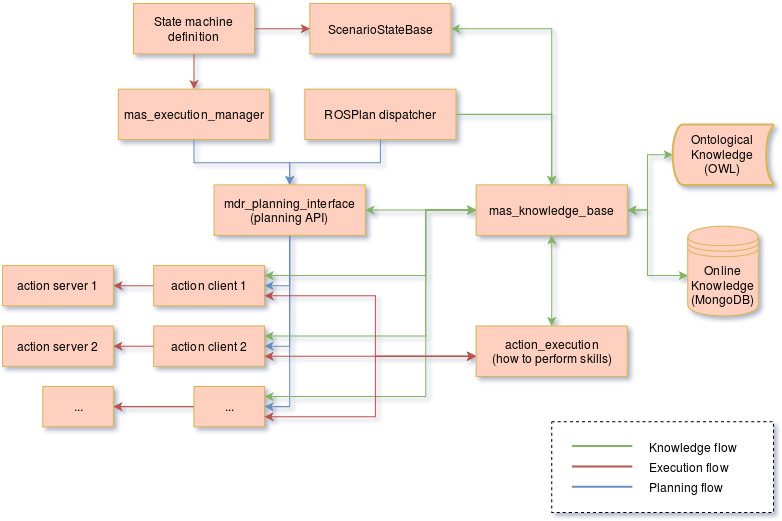

In [3]:
IPython.core.display.Image('https://raw.githubusercontent.com/b-it-bots/mas_domestic_robotics/devel/docs/planning_flowchart.png', embed=True)

## Common Interfaces in mas_domestic_robotics

To simplify the implementation of robot-dependent functionalities, the `mas_domestic_robotics` repository defines various robot-independent interfaces that can then be implemented for a specific robot. For instance, the `mdr_sound_vocalisation` package defines the following base class (defined [here](https://github.com/b-it-bots/mas_domestic_robotics/blob/devel/mdr_hri/mdr_sound_vocalisation/ros/src/mdr_sound_vocalisation/sound_vocaliser_base.py)) for implementing functionalities related to making robot sounds:

In [ ]:
import rospy

from std_msgs.msg import String

class SoundVocaliserBase(object):
    def __init__(self):
        self.speech_request_topic = rospy.get_param('~speech_request_topic', '/say')
        self.sound_request_topic = rospy.get_param('~sound_request_topic', '/make_sound')
        self.speech_topic = rospy.get_param('~speech_topic', '/sound/say')
        self.sound_topic = rospy.get_param('~sound_topic', '/sound/make')

        self.speech_request_sub = rospy.Subscriber(self.speech_request_topic,
                                                   String,
                                                   self.say)
        self.sound_request_sub = rospy.Subscriber(self.sound_request_topic,
                                                  String,
                                                  self.make_sound)

    def say(self, msg):
        rospy.loginfo('[SAY] Ignoring request')

    def make_sound(self, msg):
        rospy.loginfo('[MAKE_SOUND] Ignoring request')

A similar interface is provided by the `mdr_gripper_controller` package, which defines an interface to an end-effector of a robot manipulator (the definition is [here](https://github.com/b-it-bots/mas_domestic_robotics/blob/devel/mdr_manipulation/mdr_gripper_controller/ros/src/mdr_gripper_controller/gripper_controller_base.py)):

In [ ]:
import rospy

class GripperControllerBase(object):
    def open(self):
        rospy.loginfo('[OPEN_GRIPPER] Ignoring request')
        raise NotImplementedError()

    def close(self):
        rospy.loginfo('[CLOSE_GRIPPER] Ignoring request')
        raise NotImplementedError()

    def init_grasp_verification(self):
        rospy.loginfo('[INIT_GRASP_VERIFICATION] Ignoring request')
        raise NotImplementedError()

    def verify_grasp(self):
        rospy.loginfo('[VERIFY_GRASP] Ignoring request')
        raise NotImplementedError()

Another good example is an interface for implementing action clients (namely components that wait for action requests, execute an action, and update the knowledge base after the execution), which is implemented in the `mdr_rosplan_interface` package (in particular [here](https://github.com/b-it-bots/mas_domestic_robotics/blob/devel/mdr_planning/mdr_rosplan_interface/ros/src/mdr_rosplan_interface/action_client_base.py)):

In [ ]:
import abc

import rospy
import rosplan_dispatch_msgs.msg as plan_dispatch_msgs
import diagnostic_msgs.msg as diag_msgs
from mas_knowledge_base.domestic_kb_interface import DomesticKBInterface

class ActionClientBase(object):
    def __init__(self):
        self.action_success_msg = 'action achieved'
        self.action_failure_msg = 'action failed'

        # unique action ID
        self.action_id = -1

        # name of the robot on which the client is spawned
        self.robot_name = None

        # name of the action (converted to lowercase)
        self.action_name = rospy.get_param('~action_name', '')
        self.action_name = self.action_name.lower()

        # name of the action server
        self.action_server_name = rospy.get_param('~server_name', '')

        # timeout for action calls
        self.action_timeout = rospy.get_param('~action_timeout', 15.)

        # knowledge base interface instance
        self.kb_interface = DomesticKBInterface()

        # subscriber for dispatched actions
        rospy.Subscriber('action_dispatch_topic',
                         plan_dispatch_msgs.ActionDispatch,
                         self.call_action)

        # action feedback publisher
        self.feedback_pub = rospy.Publisher('action_feedback_topic',
                                            plan_dispatch_msgs.ActionFeedback,
                                            queue_size=1)

    @abc.abstractmethod
    def call_action(self, msg):
        '''Abstract callback for the dispatched action subscriber.
        Only reacts to request to "self.action_name"; ignores all other requests.

        Keyword arguments:
        msg -- a rosplan_dispatch_msgs.msg.ActionDispatch instance

        '''
        pass

    @abc.abstractmethod
    def get_action_message(self, rosplan_action_msg):
        '''Abstract method for converting the message to an action request.
        Returns an actionlib goal instance for the action.

        Keyword arguments:
        rosplan_action_msg -- a rosplan_dispatch_msgs.msg.ActionDispatch instance

        '''
        return None

    @abc.abstractmethod
    def update_knowledge_base(self):
        '''Abstract method for updating the knowledge base after
        the successful completion of an action.
        '''
        pass

    def send_action_feedback(self, success):
        '''Publishes a rosplan_dispatch_msgs.msg.ActionFeedback message
        based on the result of the action execution.

        Keyword arguments:
        success -- a Boolean indicating whether the action was successfully executed

        '''
        msg = plan_dispatch_msgs.ActionFeedback()
        msg.action_id = self.action_id
        if success:
            msg.status = self.action_success_msg
        else:
            msg.status = self.action_failure_msg

        action_name_kvp = diag_msgs.KeyValue()
        action_name_kvp.key = 'action_name'
        action_name_kvp.value = self.action_name
        msg.information.append(action_name_kvp)

        self.feedback_pub.publish(msg)

The above interfaces illustrate a general pattern that we want to follow in our architecture, namely we want to **create abstractions** of functionalities that can then be extended for a very particular purpose. This is simply a good software engineering practice that we try to follow in our architecture.

## Fault-Tolerant Actions

Robots are unfortunately very error-prone, so this aspect has to be taken into account in the development of robot functionalities. As mentioned above, the `mas_execution_manager` repositories includes an interface for implementing actions in a fault-tolerant manner, which is shown below for convenience (the definition of the interface is [here](https://github.com/b-it-bots/mas_execution_manager/blob/master/common/mas_execution/action_sm_base.py)):

In [ ]:
from abc import abstractmethod
from pyftsm.ftsm import FTSM, FTSMTransitions

class ActionSMBase(FTSM):
    def __init__(self, name, dependencies, max_recovery_attempts=1):
        super(ActionSMBase, self).__init__(name, dependencies, max_recovery_attempts)
        self.execution_requested = False
        self.goal = None
        self.result = None

    def init(self):
        return FTSMTransitions.INITIALISED

    def configuring(self):
        return FTSMTransitions.DONE_CONFIGURING

    def ready(self):
        if self.execution_requested:
            self.result = None
            self.execution_requested = False
            return FTSMTransitions.RUN
        else:
            if self.result:
                self.result = None
            return FTSMTransitions.WAIT

    def running(self):
        return FTSMTransitions.DONE

    def recovering(self):
        return FTSMTransitions.DONE_RECOVERING

    @abstractmethod
    def set_result(self, success):
        pass

This interface defines a so-called fault-tolerant state machine (FTSM), which is illustrated in the diagram below:

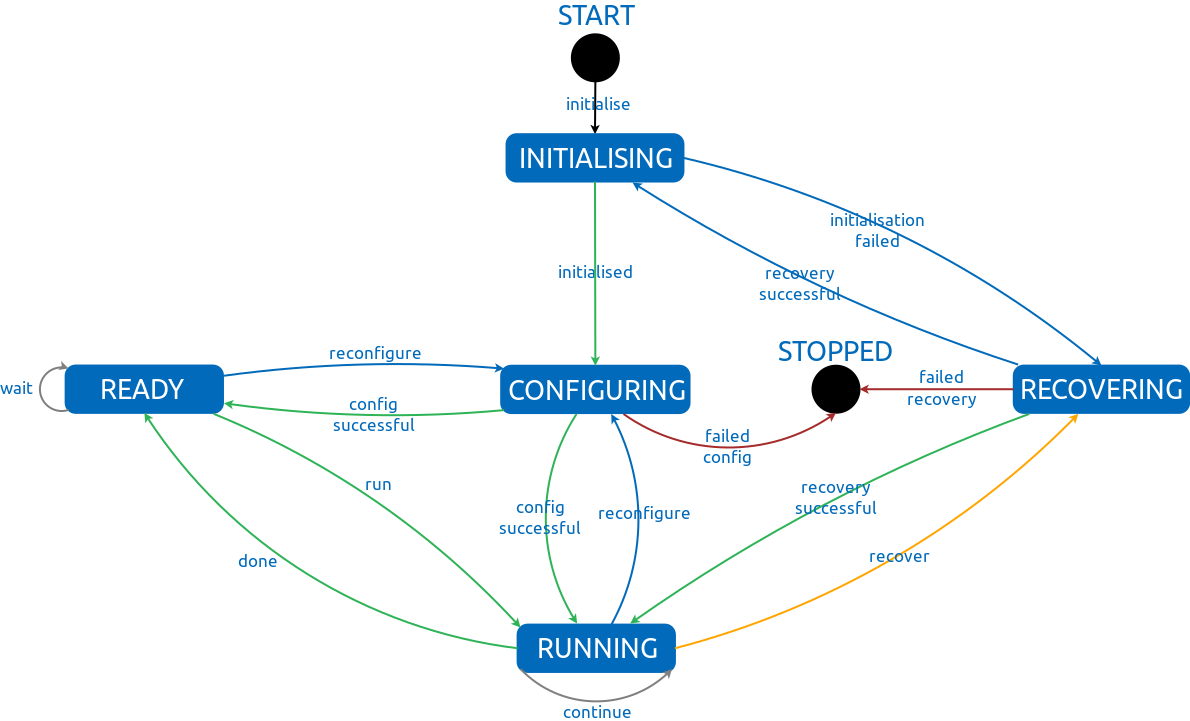

In [4]:
IPython.core.display.Image('https://raw.githubusercontent.com/b-it-bots/ftsm/master/docs/figures/fault_tolerant_state_machine.png', embed=True)

This component is a very recent addition to our set of libraries, such that almost all our actions are implemented by reusing this abstraction. There is clearly a connection between the fault-tolerant implementation of actions and the ontology in the `action-execution` library (but the integration of the two is ongoing work).

## Skill Implementation Use Case: Move Base

Implementing skills in our domestic code base is always a three-step process:

1. **The action needs to be implemented as a component inheriting from the `ActionSMBase` class described above**. Not all states of the state machine have to be overriden, but it usually makes sense to override `init` for initialising the action (e.g. by waiting for its dependencies to become available), `running` for actually performing the action, and `recovering` for specifying what needs to happen if the action fails.
2. **An actionlib server for exposing the action needs to be defined**
3. **An action client inheriting from the `ActionClientBase` shown above needs to be exposed**. The action client
    1. calls the action through the above actionlib server and
    2. updates the knowledge base after the execution is complete

This process is exemplified below for the `move_base` action, which is defined [here](https://github.com/b-it-bots/mas_domestic_robotics/tree/devel/mdr_planning/mdr_actions/mdr_navigation_actions/mdr_move_base_action).

### Action FTSM Implementation

Our `move_base` action assumes that a robot with a manipulator is used, such that the manipulator is brought to a safe position before the robot starts moving. In the `init` method of the state machine, we thus wait for the server of the `move_arm` action to become available.

The `running` method of the state machine is where the logic behind executing the action is implemented. In our case, we can move to either a named target (named targets are expected to be defined in a YAML file such as [this one](https://github.com/b-it-bots/mas_common_robotics/blob/kinetic/mcr_environments/mcr_default_env_config/brsu-c069/navigation_goals.yaml)) or an explicitly specified pose. Either way, the arm is moved to a safe configuration before the robot starts moving.

The complete implementation of the action FTSM is included below for convenience.

In [ ]:
import yaml
import rospy
import actionlib
import tf
from geometry_msgs.msg import PoseStamped, Quaternion
import move_base_msgs.msg as move_base_msgs

from pyftsm.ftsm import FTSMTransitions
from mas_execution.action_sm_base import ActionSMBase
from mdr_move_arm_action.msg import MoveArmAction, MoveArmGoal
from mdr_move_base_action.msg import MoveBaseGoal, MoveBaseFeedback, MoveBaseResult

class MoveBaseSM(ActionSMBase):
    def __init__(self, timeout=120.,
                 safe_arm_joint_config='folded',
                 move_arm_server='move_arm_server',
                 move_base_server='/move_base',
                 pose_description_file='',
                 pose_frame='map',
                 max_recovery_attempts=1):
        super(MoveBaseSM, self).__init__('MoveBase', [], max_recovery_attempts)
        self.pose = None
        self.safe_arm_joint_config = safe_arm_joint_config
        self.move_arm_server = move_arm_server
        self.move_base_server = move_base_server
        self.pose_description_file = pose_description_file
        self.pose_frame = pose_frame
        self.timeout = timeout
        self.move_arm_client = None

    def init(self):
        try:
            self.move_arm_client = actionlib.SimpleActionClient(self.move_arm_server, MoveArmAction)
            rospy.loginfo('[move_base] Waiting for %s server', self.move_arm_server)
            self.move_arm_client.wait_for_server()
        except:
            rospy.logerr('[move_base] %s server does not seem to respond', self.move_arm_server)
        return FTSMTransitions.INITIALISED

    def running(self):
        rospy.loginfo('[move_base] Moving the arm to a safe configuration...')
        move_arm_goal = MoveArmGoal()
        move_arm_goal.goal_type = MoveArmGoal.NAMED_TARGET
        move_arm_goal.named_target = self.safe_arm_joint_config
        self.move_arm_client.send_goal(move_arm_goal)
        self.move_arm_client.wait_for_result()

        pose = PoseStamped()
        if self.goal.goal_type == MoveBaseGoal.NAMED_TARGET:
            destination = self.goal.destination_location
            rospy.loginfo('[move_base] Moving base to %s', destination)

            self.pose = self.convert_pose_name_to_coordinates(destination)
            pose.header.stamp = rospy.Time.now()
            pose.header.frame_id = self.pose_frame
            pose.pose.position.x = self.pose[0]
            pose.pose.position.y = self.pose[1]

            quat = tf.transformations.quaternion_from_euler(0, 0, self.pose[2])
            pose.pose.orientation = Quaternion(*quat)
        elif self.goal.goal_type == MoveBaseGoal.POSE:
            pose = self.goal.pose
            rospy.loginfo('[move_base] Moving base to %s', pose)
        else:
            rospy.logerr('[move_base] Received an unknown goal type; ignoring request')
            self.result = self.set_result(False)
            return FTSMTransitions.DONE

        goal = move_base_msgs.MoveBaseGoal()
        goal.target_pose = pose

        move_base_client = actionlib.SimpleActionClient(self.move_base_server,
                                                        move_base_msgs.MoveBaseAction)
        move_base_client.wait_for_server()
        move_base_client.send_goal(goal)
        success = move_base_client.wait_for_result()

        if success:
            rospy.loginfo('[move_base] Pose reached successfully')
            self.result = self.set_result(True)
            return FTSMTransitions.DONE

        rospy.logerr('[move_base] Pose could not be reached')
        self.result = self.set_result(False)
        return FTSMTransitions.DONE

    def convert_pose_name_to_coordinates(self, pose_name):
        stream = open(self.pose_description_file, 'r')
        poses = yaml.load(stream)
        stream.close()
        try:
            coordinates = poses[pose_name]
            return coordinates
        except:
            rospy.logerr('Pose name "%s" does not exist' % (pose_name))
            return None

    def set_result(self, success):
        result = MoveBaseResult()
        result.success = success
        return result

### Action Server

The `move_base` action server, which is shown below, simply reads the necessary parameters for the action and then waits for action requests. This action server implementation is in fact a template that all our action server are following.

In [ ]:
import rospy
import actionlib

from mdr_move_base_action.msg import MoveBaseAction
from mdr_move_base_action.action_states import MoveBaseSM

class MoveBaseServer(object):
    '''A server exposing a go to action.
    The server expects the following parameters to be made available on the ROS parameter server:
    * move_base_server: Name of the default move_base server (default: '/move_base')
    * pose_description_file: Name of a yaml file in which named goals are mapped
                             to actual coordinates
    * pose_frame: Name of the frame in which the poses in pose_description_file
                  are given (default: 'map')
    * safe_arm_joint_config: Name of a configuration specified in which the robot can
                             safely move around the environment (default: 'folded')
    * move_arm_server: Name of the move_arm action server (default: 'move_arm_server')
    @author Alex Mitrevski
    @contact aleksandar.mitrevski@h-brs.de
    '''
    def __init__(self):
        safe_arm_joint_config = rospy.get_param('~safe_arm_joint_config', 'folded')
        move_arm_server = rospy.get_param('~move_arm_server', 'move_arm_server')
        move_base_server = rospy.get_param('~move_base_server', '')
        pose_description_file = rospy.get_param('~pose_description_file', '')
        pose_frame = rospy.get_param('~pose_frame', '')

        rospy.loginfo('[move_base] Initialising state machine')
        self.action_sm = MoveBaseSM(safe_arm_joint_config=safe_arm_joint_config,
                                    move_arm_server=move_arm_server,
                                    move_base_server=move_base_server,
                                    pose_description_file=pose_description_file,
                                    pose_frame=pose_frame)
        rospy.loginfo('[move_base] State machine initialised')

        self.action_server = actionlib.SimpleActionServer('move_base_server',
                                                          MoveBaseAction,
                                                          self.execute, False)
        self.action_server.start()
        rospy.loginfo('move_base action server ready')

    def execute(self, goal):
        rospy.loginfo('[move_base] Received an action request')
        self.action_sm.goal = goal
        self.action_sm.result = None
        self.action_sm.execution_requested = True
        while not self.action_sm.result:
            rospy.sleep(0.05)
        self.action_server.set_succeeded(self.action_sm.result)

if __name__ == '__main__':
    rospy.init_node('move_base_server')
    move_base_server = MoveBaseServer()
    try:
        move_base_server.action_sm.run()
        while move_base_server.action_sm.is_running and not rospy.is_shutdown():
            rospy.spin()
    except (KeyboardInterrupt, SystemExit):
        print('{0} interrupted; exiting...'.format(move_base_server.action_sm.name))
        move_base_server.action_sm.stop()

### Action Client

Finally, the `move_base` action client simply waits for action requests from a plan/task dispatcher, calls the action server, and, if the action completes successfully, updates the knowledge base with the fact that the robot is now at its destination location rather than at its original location. The implementation of the `move_base` action client is given below.

In [ ]:
import rospy
import actionlib

from mdr_rosplan_interface.action_client_base import ActionClientBase
from mdr_move_base_action.msg import MoveBaseAction, MoveBaseGoal

class MoveBaseClient(ActionClientBase):
    def __init__(self):
        super(MoveBaseClient, self).__init__()
        self.original_location = ''

        while not rospy.is_shutdown():
            rospy.sleep(0.1)

    def call_action(self, msg):
        # we only react to calls to this action
        if self.action_name != msg.name.lower():
            return

        self.action_id = msg.action_id

        client = actionlib.SimpleActionClient(self.action_server_name, MoveBaseAction)
        client.wait_for_server()
        goal = self.get_action_message(msg)

        # calling the actionlib server and waiting for the execution to end
        rospy.loginfo('Sending action lib goal to move_base_server,' +
                      ' destination: ' + goal.destination_location)
        client.send_goal(goal)
        client.wait_for_result(rospy.Duration.from_sec(int(self.action_timeout)))
        result = client.get_result()

        if result and result.success:
            rospy.loginfo('[MOVE_BASE] Updating the knowledge base')
            self.update_knowledge_base(goal.destination_location)
            self.send_action_feedback(True)
        else:
            self.send_action_feedback(False)

    def get_action_message(self, rosplan_action_msg):
        '''Reads the action parameters and uses them to initialise an actionlib message.
        '''
        goal = MoveBaseGoal()
        for param in rosplan_action_msg.parameters:
            if param.key == 'from':
                self.original_location = param.value
            elif param.key == 'to':
                goal.destination_location = param.value
            elif param.key == 'bot':
                self.robot_name = param.value
        goal.goal_type = MoveBaseGoal.NAMED_TARGET
        return goal

    def update_knowledge_base(self, destination_location):
        '''Updates the knowledge base with the following facts:
        * the robot is not at the original location anymore
        * the robot is at the destination location
        '''
        facts_to_add = [('robot_at', [('bot', self.robot_name), ('wp', destination_location)])]
        facts_to_remove = [('robot_at', [('bot', self.robot_name), ('wp', self.original_location)])]
        self.kb_interface.update_kb(facts_to_add, facts_to_remove)

if __name__ == '__main__':
    rospy.init_node('mdr_move_base_client')
    try:
        MoveBaseClient()
    except rospy.ROSInterruptException:
        pass

## Scenario Use Case: Simple Pick and Place

One interesting aspect about our architecture is the creation of a complex scenario that a robot can execute. Most of the time, we define scenarios using state machines, such that we use the components in `mas_execution_manager` for defining and executing state machines. A description of `mas_execution_manager` is beyond the scope of this tutorial; please read the [package documentation](https://github.com/b-it-bots/mas_execution_manager) for that.

### Scenario Description

Instead, let's consider an example to illustrate how we could define a state machine for a scenario in which we want a robot to perform a very simple perpetual pick-and-place functionality (this is one of our lab demos defined [here](https://github.com/b-it-bots/mas_domestic_robotics/tree/devel/mdr_planning/mdr_scenarios/mdr_demos/mdr_demo_simple_pick_and_place)). In particular, let's assume that we want the robot to:

1. go to a table in the lab
2. scan the table for any objects
3. pick the closest object from the table
4. place the object back on the table
5. repeat 2-4 until the execution is manually terminated

We also want to have some recovery in the execution; in particular, we want the robot to repeat the execution if it detects a failure in each of the states, such that if we have consecutive failures in a given state for a predefined number of times, the state machine will be interrupted.

### Scenario State Machine Definition

We can encode this scenario using the YAML-based state machine specification described in `mas_execution_manager` as follows:

```yaml
sm_id: mdr_demo_simple_pick_and_place
states: [GO_TO_TABLE, PERCEIVE_TABLE, PICK_OBJECT, PLACE_OBJECT]
outcomes: [FAILED]
state_descriptions:
    - state:
        name: GO_TO_TABLE
        state_module_name: mdr_navigation_behaviours.move_base
        state_class_name: MoveBase
        transitions:
            - transition:
                name: succeeded
                state: PERCEIVE_TABLE
            - transition:
                name: failed
                state: GO_TO_TABLE
            - transition:
                name: failed_after_retrying
                state: FAILED
        arguments:
            - argument:
                name: destination_locations
                value: [TABLE]
            - argument:
                name: number_of_retries
                value: 3
    - state:
        name: PERCEIVE_TABLE
        state_module_name: mdr_perception_behaviours.perceive_planes
        state_class_name: PerceivePlanes
        transitions:
            - transition:
                name: succeeded
                state: PICK_OBJECT
            - transition:
                name: failed
                state: PERCEIVE_TABLE
            - transition:
                name: failed_after_retrying
                state: FAILED
        arguments:
            - argument:
                name: number_of_retries
                value: 3
            - argument:
                name: plane_prefix
                value: table
    - state:
        name: PICK_OBJECT
        state_module_name: mdr_manipulation_behaviours.pick_closest_from_surface
        state_class_name: PickClosestFromSurface
        transitions:
            - transition:
                name: succeeded
                state: PLACE_OBJECT
            - transition:
                name: failed
                state: PICK_OBJECT
            - transition:
                name: failed_after_retrying
                state: FAILED
            - transition:
                name: find_objects_before_picking
                state: PERCEIVE_TABLE
        arguments:
            - argument:
                name: number_of_retries
                value: 3
            - argument:
                name: picking_surface_prefix
                value: table
    - state:
        name: PLACE_OBJECT
        state_module_name: mdr_manipulation_behaviours.place
        state_class_name: Place
        transitions:
            - transition:
                name: succeeded
                state: PERCEIVE_TABLE
            - transition:
                name: failed
                state: PLACE_OBJECT
            - transition:
                name: failed_after_retrying
                state: FAILED
        arguments:
            - argument:
                name: number_of_retries
                value: 3
            - argument:
                name: placing_surface_prefix
                value: table
```

The resulting state machine from this scenario definition is shown below:

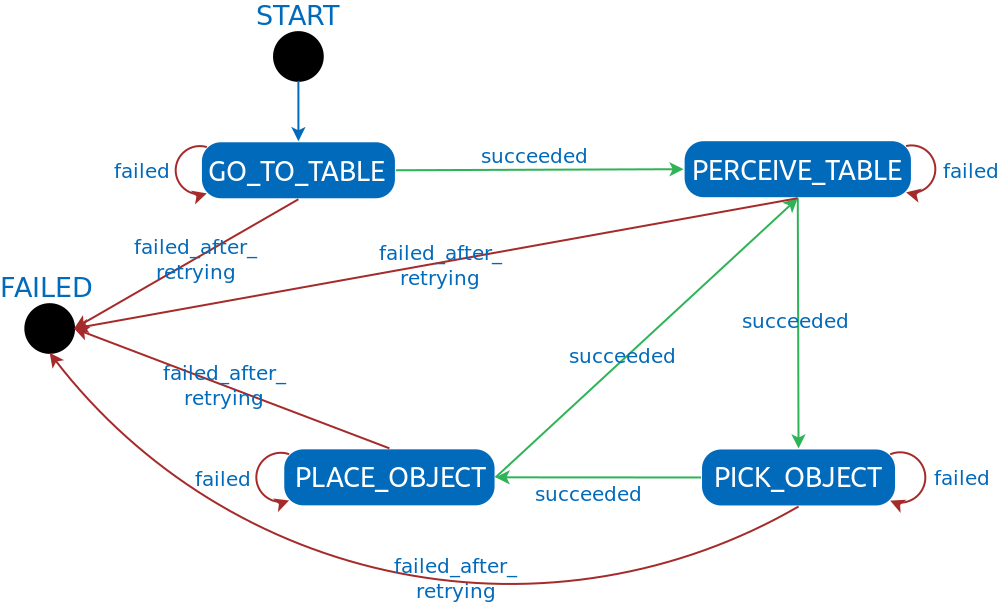

In [5]:
IPython.core.display.Image('images/simple_pick_and_place_sm.png', embed=True)

In the state machine definition file, the `state_module_name` and `state_class_name` specify the package and class name that define the state that will be executed (states are thus dynamically loaded from the configuration file rather than hard-coded in a scenario script). In this particular case, all states are reused from the `mdr_behaviours` metapackage, but they could also be redefined for a specific scenario to capture any particular nuances about the scenario.

### Example Behaviour Implementation: Move Base

Behaviours are implemented as smach states that inherit from a `ScenarioStateBase` class defined in `mas_execution_manager`. To interact with the skills, the behaviours use the action clients described above, i.e. skills are not invoked by creating an actionlib action client, but by sending a message to the action client much like a plan dispatcher (though there is nothing preventing one from creating an explicit client instead).

An example implementation of the `move_base` behaviour used in the above `GO_TO_TABLE` state that illustrates this principle is shown below (this behaviour can be found [here](https://github.com/b-it-bots/mas_domestic_robotics/blob/devel/mdr_planning/mdr_behaviours/mdr_navigation_behaviours/ros/src/mdr_navigation_behaviours/move_base.py)):

In [ ]:
import time
import rospy
import actionlib

import rosplan_dispatch_msgs.msg as plan_dispatch_msgs
import diagnostic_msgs.msg as diag_msgs

from mdr_move_base_action.msg import MoveBaseAction
from mas_execution_manager.scenario_state_base import ScenarioStateBase

class MoveBase(ScenarioStateBase):
    def __init__(self, save_sm_state=False, **kwargs):
        ScenarioStateBase.__init__(self, 'move_base',
                                   save_sm_state=save_sm_state,
                                   outcomes=['succeeded', 'failed', 'failed_after_retrying'])
        self.sm_id = kwargs.get('sm_id', '')
        self.state_name = kwargs.get('state_name', 'move_base')
        self.move_base_server = kwargs.get('move_base_server', 'move_base_server')
        self.destination_locations = list(kwargs.get('destination_locations', list()))
        self.timeout = kwargs.get('timeout', 120.)

        self.number_of_retries = kwargs.get('number_of_retries', 0)
        self.retry_count = 0

    def execute(self, userdata):
        original_location = self.kb_interface.get_robot_location(self.robot_name)
        for destination_location in self.destination_locations:
            dispatch_msg = self.get_dispatch_msg(original_location,
                                                 destination_location)

            rospy.loginfo('Sending the base to %s' % destination_location)
            self.say('Going to ' + destination_location)
            self.action_dispatch_pub.publish(dispatch_msg)

            self.executing = True
            self.succeeded = False
            start_time = time.time()
            duration = 0.
            while self.executing and duration < self.timeout:
                rospy.sleep(0.1)
                duration = time.time() - start_time

            if self.succeeded:
                rospy.loginfo('Successfully reached %s' % destination_location)
                original_location = destination_location
            else:
                rospy.logerr('Could not reach %s' % destination_location)
                self.say('Could not reach ' + destination_location)
                if self.retry_count == self.number_of_retries:
                    self.say('Aborting operation')
                    return 'failed_after_retrying'
                self.retry_count += 1
                return 'failed'
        return 'succeeded'

    def get_dispatch_msg(self, original_location, destination_location):
        dispatch_msg = plan_dispatch_msgs.ActionDispatch()
        dispatch_msg.name = self.action_name

        arg_msg = diag_msgs.KeyValue()
        arg_msg.key = 'bot'
        arg_msg.value = self.robot_name
        dispatch_msg.parameters.append(arg_msg)

        arg_msg = diag_msgs.KeyValue()
        arg_msg.key = 'from'
        arg_msg.value = original_location
        dispatch_msg.parameters.append(arg_msg)

        arg_msg = diag_msgs.KeyValue()
        arg_msg.key = 'to'
        arg_msg.value = destination_location
        dispatch_msg.parameters.append(arg_msg)

        return dispatch_msg

## About This Tutorial

**Author(s)**: Alex Mitrevski

**Contributors**: Minh Nguyen, Argentina Ortega

**Last update**: 23.02.2019